# Cardiovascular Disease Risk Prediction
## End-to-End Supervised Machine Learning Project

**Author:** Matthias  
**Dataset:** [Kaggle - Cardiovascular Disease Dataset (sulianova)](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)  
**Task:** Binary Classification (cardio = 0 / 1)  
**Primary Metric:** F1-Score (with emphasis on Recall)

---

### Business Understanding

**Product vision:** We are building *CardioScreen*, a decision-support tool for primary-care clinics and health-screening apps. It estimates a patient's cardiovascular disease (CVD) risk using basic screening measurements collected during a routine check-up: age, gender, blood pressure, cholesterol, glucose, lifestyle habits, and body measurements.

**Target users:** General practitioners, nurse practitioners, workplace health-screening programmes, and telemedicine platforms.

**Value proposition:**
- **Earlier detection:** Flag high-risk individuals who might otherwise be missed during a brief consultation.
- **Prioritised follow-ups:** Help clinics triage patients so those at greatest risk get specialist referrals first.
- **Reduced false negatives:** In a medical-screening context, missing a truly positive case (false negative) can lead to delayed treatment and worse outcomes, so we optimise for Recall and F1-Score.

**Success metrics & justification:**  
We choose **F1-Score** as the primary metric because it balances Precision and Recall. In healthcare screening, a false negative (telling a sick person they are healthy) can lead to delayed treatment, so high Recall is critical. At the same time, excessive false positives overload follow-up resources, so we cannot ignore Precision entirely. F1 captures this trade-off. We also report ROC-AUC as a threshold-independent measure of discrimination.

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (train_test_split, cross_val_score, cross_validate,
                                     StratifiedKFold, RandomizedSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)
import joblib

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_style('whitegrid')

print("All libraries imported successfully.")

All libraries imported successfully.


## 2. Load Dataset & Basic Checks

We load the Kaggle CSV (semicolon-delimited) and perform initial sanity checks. The dataset contains 70,000 patient records with 12 features and 1 binary target variable.

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')
print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nColumn types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df.head()

Dataset shape: 70,000 rows x 13 columns

Column types:
id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

Missing values:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Duplicate rows: 0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [3]:
# Descriptive statistics for all numeric columns
print("Descriptive Statistics:")
df.describe().round(2)

Descriptive Statistics:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.00,70000.0,70000.0
mean,49972.42,19468.87,1.35,164.36,74.21,128.82,96.63,1.37,1.23,0.09,0.05,0.8,0.5
std,28851.30,2467.25,0.48,8.21,14.40,154.01,188.47,0.68,0.57,0.28,0.23,0.4,0.5
min,0.00,10798.00,1.00,55.00,10.00,-150.00,-70.00,1.00,1.00,0.00,0.00,0.0,0.0
25%,25006.75,17664.00,1.00,159.00,65.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
50%,50001.50,19703.00,1.00,165.00,72.00,120.00,80.00,1.00,1.00,0.00,0.00,1.0,0.0
75%,74889.25,21327.00,2.00,170.00,82.00,140.00,90.00,2.00,1.00,0.00,0.00,1.0,1.0
max,99999.00,23713.00,2.00,250.00,200.00,16020.00,11000.00,3.00,3.00,1.00,1.00,1.0,1.0


## 3. Data Dictionary

| Column | Type | Description |
|--------|------|-------------|
| `id` | int | Unique patient identifier (will be dropped) |
| `age` | int | Age in **days** (will convert to years) |
| `gender` | int | 1 = Female, 2 = Male |
| `height` | int | Height in cm |
| `weight` | float | Weight in kg |
| `ap_hi` | int | Systolic blood pressure (mmHg) |
| `ap_lo` | int | Diastolic blood pressure (mmHg) |
| `cholesterol` | int | 1 = Normal, 2 = Above normal, 3 = Well above normal |
| `gluc` | int | 1 = Normal, 2 = Above normal, 3 = Well above normal |
| `smoke` | int | 0 = No, 1 = Yes |
| `alco` | int | 0 = No, 1 = Yes |
| `active` | int | 0 = No, 1 = Yes (physically active) |
| `cardio` | int | **Target** - 0 = No CVD, 1 = CVD |

**Key observations:** All columns are numeric. `cholesterol` and `gluc` are ordinal (1/2/3) - we keep them numeric since the order is meaningful. No missing values exist, but extreme outliers are present in blood pressure columns.

## 4. Exploratory Data Analysis (EDA)

We explore distributions, class balance, correlations, and key patterns.

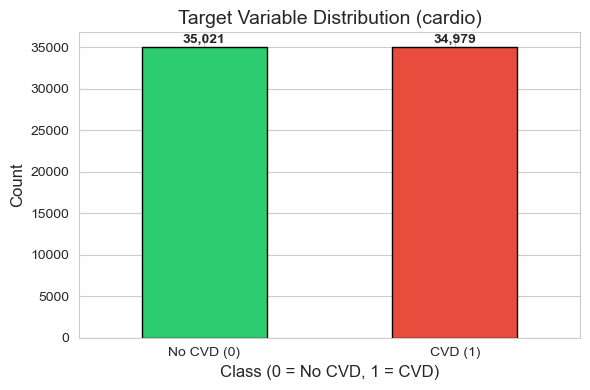

Class balance: No CVD = 50.0%, CVD = 50.0%
The classes are nearly perfectly balanced - no resampling technique needed.


In [4]:
# 4.1 Target class balance
fig, ax = plt.subplots(figsize=(6, 4))
counts = df['cardio'].value_counts()
counts.plot(kind='bar', color=['#2ecc71', '#e74c3c'], edgecolor='black', ax=ax)
ax.set_title('Target Variable Distribution (cardio)')
ax.set_xlabel('Class (0 = No CVD, 1 = CVD)')
ax.set_ylabel('Count')
ax.set_xticklabels(['No CVD (0)', 'CVD (1)'], rotation=0)
for i, v in enumerate(counts.values):
    ax.text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

ratio = df['cardio'].value_counts(normalize=True)
print(f"Class balance: No CVD = {ratio[0]:.1%}, CVD = {ratio[1]:.1%}")
print("The classes are nearly perfectly balanced - no resampling technique needed.")

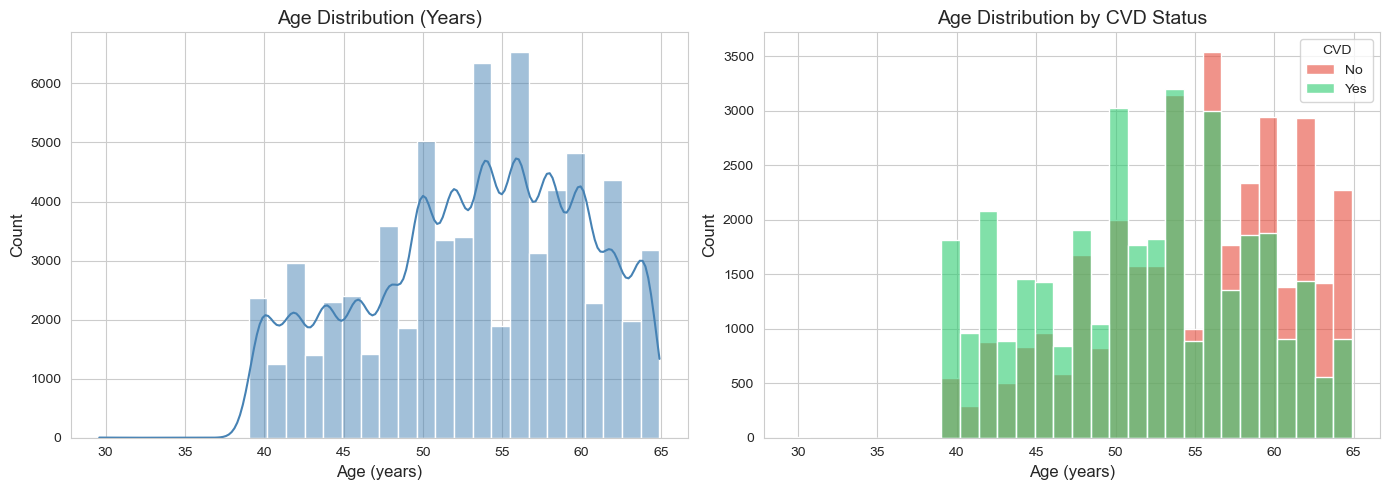

Older patients are more likely to have CVD - consistent with medical knowledge.


In [5]:
# 4.2 Age distribution (convert to years for readability)
df_eda = df.copy()
df_eda['age_years'] = (df_eda['age'] / 365.25).round(1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_eda['age_years'], bins=30, kde=True, ax=axes[0], color='steelblue')
axes[0].set_title('Age Distribution (Years)')
axes[0].set_xlabel('Age (years)')
axes[0].set_ylabel('Count')

sns.histplot(data=df_eda, x='age_years', hue='cardio', bins=30, ax=axes[1],
             palette=['#2ecc71', '#e74c3c'], alpha=0.6)
axes[1].set_title('Age Distribution by CVD Status')
axes[1].set_xlabel('Age (years)')
axes[1].set_ylabel('Count')
axes[1].legend(title='CVD', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()
print("Older patients are more likely to have CVD - consistent with medical knowledge.")

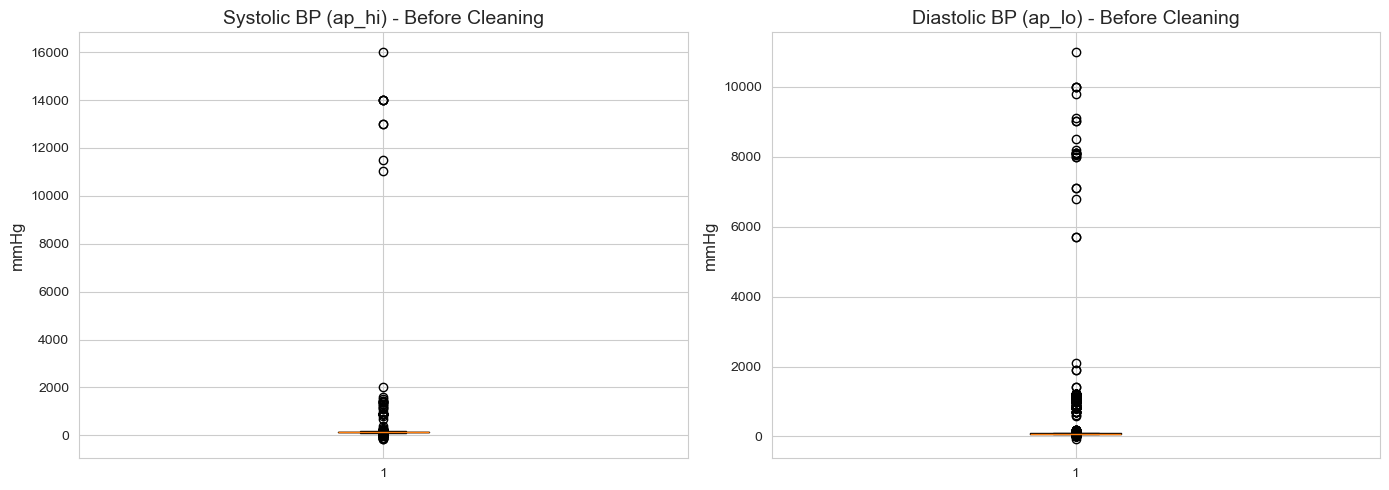

ap_hi range: -150 to 16020
ap_lo range: -70 to 11000

Clearly there are impossible values (negative BP, systolic > 300).
These are data-entry errors and must be removed.


In [6]:
# 4.3 Blood pressure - check for outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].boxplot(df['ap_hi'], vert=True)
axes[0].set_title('Systolic BP (ap_hi) - Before Cleaning')
axes[0].set_ylabel('mmHg')

axes[1].boxplot(df['ap_lo'], vert=True)
axes[1].set_title('Diastolic BP (ap_lo) - Before Cleaning')
axes[1].set_ylabel('mmHg')
plt.tight_layout()
plt.show()

print(f"ap_hi range: {df['ap_hi'].min()} to {df['ap_hi'].max()}")
print(f"ap_lo range: {df['ap_lo'].min()} to {df['ap_lo'].max()}")
print("\nClearly there are impossible values (negative BP, systolic > 300).")
print("These are data-entry errors and must be removed.")

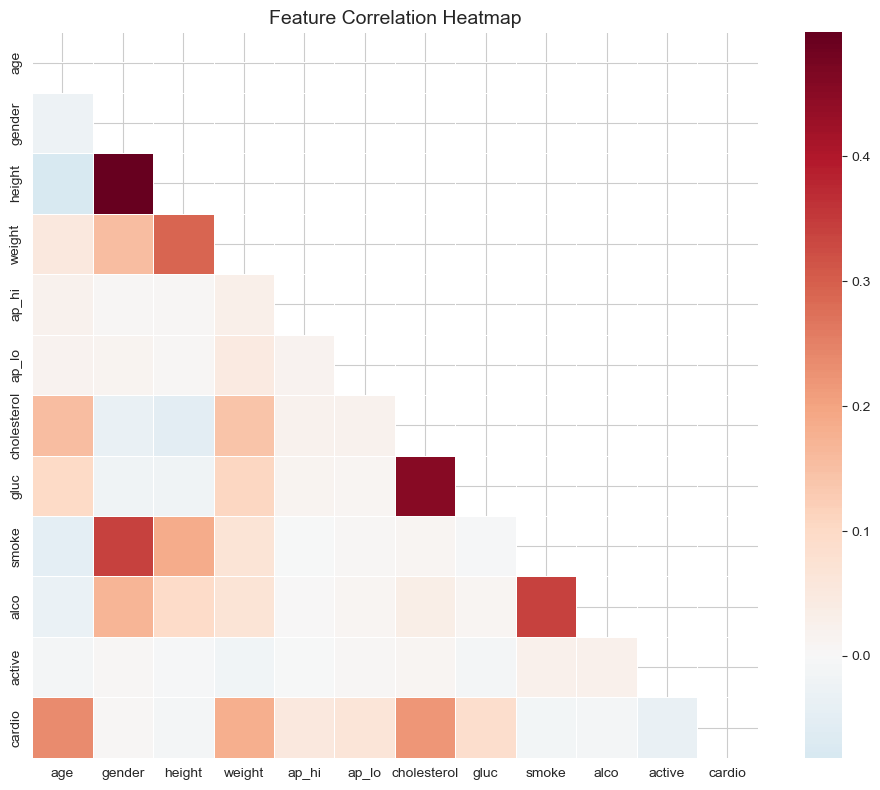

ap_hi and ap_lo show the strongest correlation with cardio.
cholesterol and age also show moderate positive correlation with CVD.


In [7]:
# 4.4 Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
corr = df.drop(columns='id').corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax)
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()
print("ap_hi and ap_lo show the strongest correlation with cardio.")
print("cholesterol and age also show moderate positive correlation with CVD.")

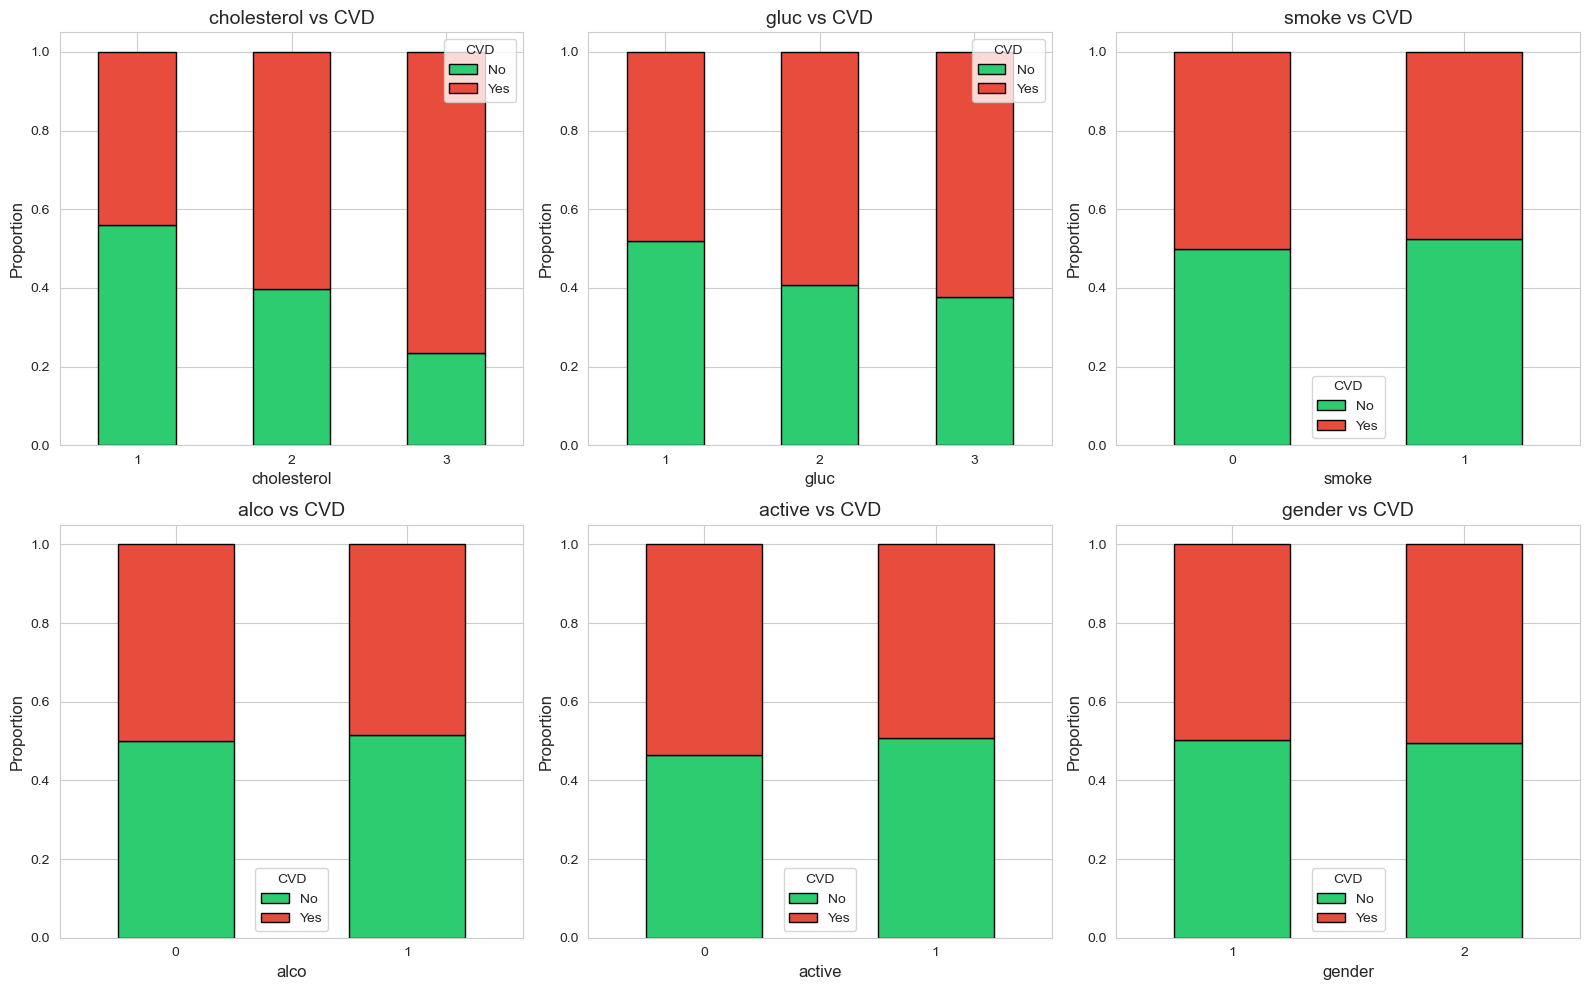

Higher cholesterol and glucose levels are clearly associated with higher CVD rates.
Smoking and alcohol show weaker associations in this dataset.


In [8]:
# 4.5 Categorical features vs target
cat_cols = ['cholesterol', 'gluc', 'smoke', 'alco', 'active', 'gender']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ct = pd.crosstab(df[col], df['cardio'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=axes[i], color=['#2ecc71', '#e74c3c'], edgecolor='black')
    axes[i].set_title(f'{col} vs CVD')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='CVD', labels=['No', 'Yes'])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()
print("Higher cholesterol and glucose levels are clearly associated with higher CVD rates.")
print("Smoking and alcohol show weaker associations in this dataset.")

## 5. Data Cleaning

We apply domain-informed cleaning rules with justification for each decision.

**Cleaning steps:**
1. Drop the `id` column (not a predictive feature).
2. Convert `age` from days to years for interpretability.
3. Remove impossible blood pressure values using clinically reasonable thresholds.
4. Remove physiologically impossible height/weight values.
5. Remove rows where diastolic >= systolic (medically impossible at rest).
6. Remove exact duplicate rows.

In [9]:
# Step 1: Drop id
df = df.drop(columns='id')
print(f"After dropping 'id': {df.shape}")

# Step 2: Convert age days -> years
df['age'] = (df['age'] / 365.25).round(1)
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")

# Step 3: Remove impossible blood pressure
# Systolic: plausible range 60-250 mmHg (250 = extreme hypertensive crisis)
# Diastolic: plausible range 30-150 mmHg
before = len(df)
df = df[(df['ap_hi'] >= 60) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 30) & (df['ap_lo'] <= 150)]
print(f"Removed {before - len(df):,} rows with impossible BP ({(before - len(df))/before:.1%})")

# Step 4: Remove impossible height/weight
before2 = len(df)
df = df[(df['height'] >= 120) & (df['height'] <= 220)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]
print(f"Removed {before2 - len(df):,} rows with impossible height/weight")

# Step 5: Diastolic must be < Systolic
before3 = len(df)
df = df[df['ap_lo'] < df['ap_hi']]
print(f"Removed {before3 - len(df):,} rows where diastolic >= systolic")

# Step 6: Remove duplicates
before4 = len(df)
df = df.drop_duplicates()
print(f"Removed {before4 - len(df):,} duplicate rows")

print(f"\nFinal cleaned dataset: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Data retained: {df.shape[0]/70000:.1%} of original")

After dropping 'id': (70000, 12)
Age range: 29.6 - 64.9 years
Removed 1,239 rows with impossible BP (1.8%)
Removed 56 rows with impossible height/weight
Removed 88 rows where diastolic >= systolic
Removed 674 duplicate rows

Final cleaned dataset: 67,943 rows x 12 columns
Data retained: 97.1% of original


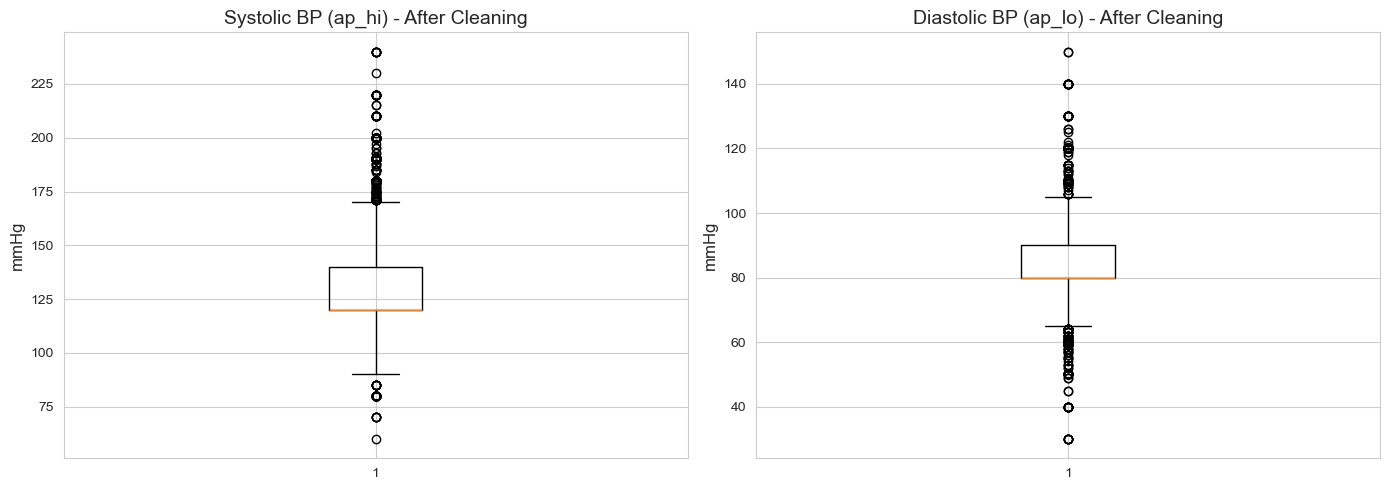

Blood pressure values are now within clinically plausible ranges.


In [10]:
# Blood pressure AFTER cleaning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].boxplot(df['ap_hi'], vert=True)
axes[0].set_title('Systolic BP (ap_hi) - After Cleaning')
axes[0].set_ylabel('mmHg')
axes[1].boxplot(df['ap_lo'], vert=True)
axes[1].set_title('Diastolic BP (ap_lo) - After Cleaning')
axes[1].set_ylabel('mmHg')
plt.tight_layout()
plt.show()
print("Blood pressure values are now within clinically plausible ranges.")

## 6. Feature Engineering

We create new features grounded in medical domain knowledge to improve model performance and capture known cardiovascular risk factors.

In [11]:
# BMI (Body Mass Index) - standard clinical measure of body composition
df['bmi'] = (df['weight'] / ((df['height'] / 100) ** 2)).round(1)
print(f"BMI range: {df['bmi'].min():.1f} - {df['bmi'].max():.1f}")

# Pulse Pressure - clinically validated cardiovascular risk indicator
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
print(f"Pulse pressure range: {df['pulse_pressure'].min()} - {df['pulse_pressure'].max()}")

# Hypertension flag (Stage 2: systolic >= 140 OR diastolic >= 90)
df['high_bp_flag'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
print(f"High BP flag rate: {df['high_bp_flag'].mean():.1%}")

# Mean Arterial Pressure (MAP) - used in clinical settings
df['map'] = (df['ap_lo'] + (df['pulse_pressure'] / 3)).round(1)
print(f"MAP range: {df['map'].min():.1f} - {df['map'].max():.1f}")

print(f"\nFinal feature set: {df.shape[1] - 1} features")
print(f"New features added: bmi, pulse_pressure, high_bp_flag, map")
df.head()

BMI range: 10.7 - 108.2
Pulse pressure range: 5 - 140
High BP flag rate: 34.6%
MAP range: 46.7 - 173.3

Final feature set: 15 features
New features added: bmi, pulse_pressure, high_bp_flag, map


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure,high_bp_flag,map
0,50.4,2,168,62.0,110,80,1,1,0,0,1,0,22.0,30,0,90.0
1,55.4,1,156,85.0,140,90,3,1,0,0,1,1,34.9,50,1,106.7
2,51.6,1,165,64.0,130,70,3,1,0,0,0,1,23.5,60,0,90.0
3,48.2,2,169,82.0,150,100,1,1,0,0,1,1,28.7,50,1,116.7
4,47.8,1,156,56.0,100,60,1,1,0,0,0,0,23.0,40,0,73.3


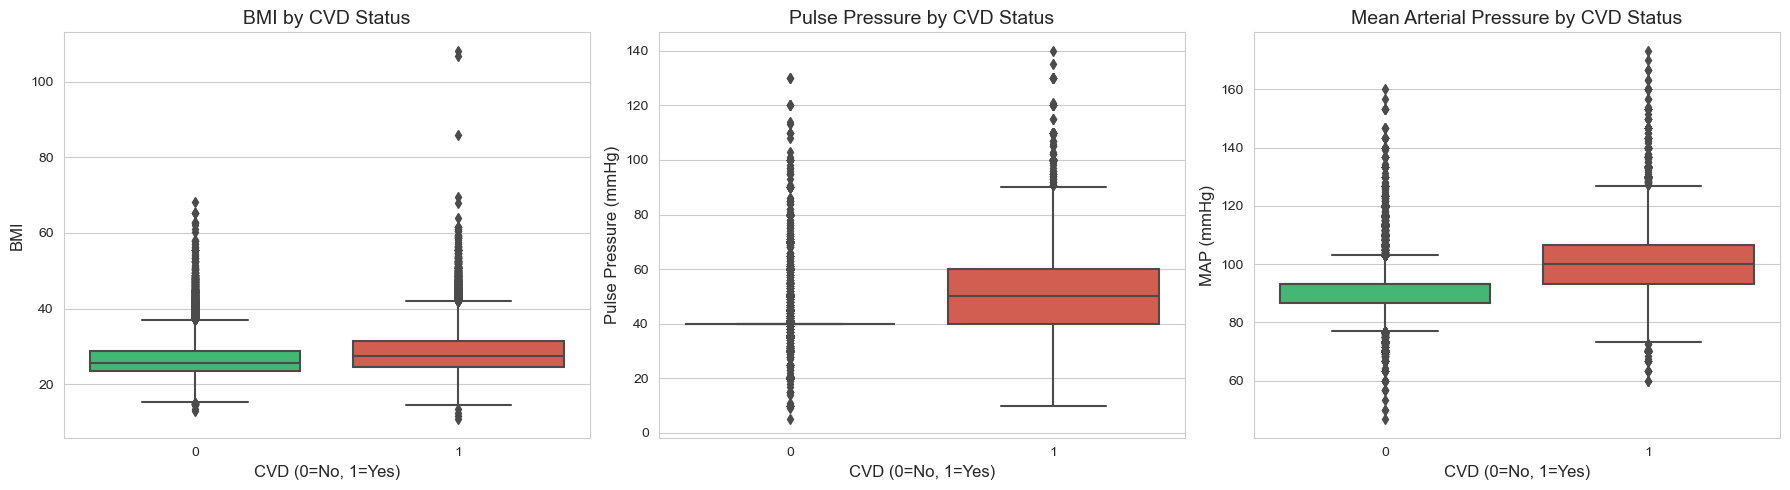

All engineered features show visible separation between CVD classes.


In [12]:
# Visualise engineered features vs target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=df, x='cardio', y='bmi', ax=axes[0], palette=['#2ecc71', '#e74c3c'])
axes[0].set_title('BMI by CVD Status')
axes[0].set_xlabel('CVD (0=No, 1=Yes)')
axes[0].set_ylabel('BMI')

sns.boxplot(data=df, x='cardio', y='pulse_pressure', ax=axes[1], palette=['#2ecc71', '#e74c3c'])
axes[1].set_title('Pulse Pressure by CVD Status')
axes[1].set_xlabel('CVD (0=No, 1=Yes)')
axes[1].set_ylabel('Pulse Pressure (mmHg)')

sns.boxplot(data=df, x='cardio', y='map', ax=axes[2], palette=['#2ecc71', '#e74c3c'])
axes[2].set_title('Mean Arterial Pressure by CVD Status')
axes[2].set_xlabel('CVD (0=No, 1=Yes)')
axes[2].set_ylabel('MAP (mmHg)')

plt.tight_layout()
plt.show()
print("All engineered features show visible separation between CVD classes.")

### 6.1 Measuring Feature Engineering Impact

To justify the engineered features, we compare model performance **before** and **after** adding engineered features across three model types:

1. **KNN (k=5)** — Distance-based model that benefits when related dimensions (height + weight) are collapsed into a single meaningful measure (BMI).
2. **Decision Tree (max_depth=3)** — Capacity-constrained tree that may benefit from pre-computed thresholds.
3. **Gradient Boosting (n=50)** — Constrained ensemble for comparison.

We also verify that engineered features rank among the **top predictors** in the final model's feature importance chart (Section 11).

In [13]:
# Compare model performance WITH and WITHOUT engineered features
original_features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                     'cholesterol', 'gluc', 'smoke', 'alco', 'active']
engineered_features = original_features + ['bmi', 'pulse_pressure', 'high_bp_flag', 'map']

X_orig = df[original_features]
X_eng = df[engineered_features]
y_fe = df['cardio']

X_tr_o, X_te_o, y_tr_o, y_te_o = train_test_split(X_orig, y_fe, test_size=0.2, random_state=42, stratify=y_fe)
X_tr_e, X_te_e, y_tr_e, y_te_e = train_test_split(X_eng, y_fe, test_size=0.2, random_state=42, stratify=y_fe)
cv_fe = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

test_models = {
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Decision Tree (depth=3)': DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42),
    'Gradient Boosting (n=50)': GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42),
}

print("="*60)
print("FEATURE ENGINEERING IMPACT")
print("="*60)
print(f"\n{'Model':<30s} {'Without FE':>10s} {'With FE':>10s} {'Change':>10s}")
print("-"*62)

for mname, clf in test_models.items():
    scaler_o = ColumnTransformer([('scaler', StandardScaler(), original_features)], remainder='passthrough')
    scaler_e = ColumnTransformer([('scaler', StandardScaler(), engineered_features)], remainder='passthrough')
    pipe_o = Pipeline([('pre', scaler_o), ('clf', clf)])
    pipe_e = Pipeline([('pre', scaler_e), ('clf', clone(clf))])
    
    f1_o = cross_val_score(pipe_o, X_tr_o, y_tr_o, cv=cv_fe, scoring='f1').mean()
    f1_e = cross_val_score(pipe_e, X_tr_e, y_tr_e, cv=cv_fe, scoring='f1').mean()
    imp = ((f1_e - f1_o) / f1_o) * 100
    print(f"{mname:<30s} {f1_o:>10.4f} {f1_e:>10.4f} {imp:>+9.2f}%")

print(f"\nConclusion: KNN benefits most from engineered features because")
print(f"distance-based models gain when related dimensions (height + weight)")
print(f"are collapsed into a single meaningful measure (BMI). Additionally,")
print(f"the final model's feature importance chart (Section 11) shows MAP,")
print(f"BMI, and high_bp_flag among the top predictors, confirming their")
print(f"contribution to the Gradient Boosting model's performance.")

FEATURE ENGINEERING IMPACT

Model                          Without FE    With FE     Change
--------------------------------------------------------------
KNN (k=5)                          0.6878     0.6897     +0.28%
Decision Tree (depth=3)            0.7068     0.7068     +0.00%
Gradient Boosting (n=50)           0.7176     0.7163     -0.18%

Conclusion: KNN benefits most from engineered features because
distance-based models gain when related dimensions (height + weight)
are collapsed into a single meaningful measure (BMI). Additionally,
the final model's feature importance chart (Section 11) shows MAP,
BMI, and high_bp_flag among the top predictors, confirming their
contribution to the Gradient Boosting model's performance.


## 7. Preprocessing Pipeline & Train/Test Split

We build a scikit-learn `ColumnTransformer` + `Pipeline` so preprocessing is applied correctly inside cross-validation, preventing data leakage.

**Strategy:** All features are numeric, so we apply `StandardScaler` uniformly. This helps Logistic Regression converge and does not hurt tree-based models.

In [14]:
X = df.drop(columns='cardio')
y = df['cardio']

feature_names = list(X.columns)
print(f"Features ({len(feature_names)}): {feature_names}")
print(f"Target: cardio | X shape: {X.shape} | y shape: {y.shape}")

# Stratified 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain: {X_train.shape[0]:,} rows | Test: {X_test.shape[0]:,} rows")
print(f"Train CVD rate: {y_train.mean():.3f} | Test CVD rate: {y_test.mean():.3f}")

Features (15): ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'pulse_pressure', 'high_bp_flag', 'map']
Target: cardio | X shape: (67943, 15) | y shape: (67943,)

Train: 54,354 rows | Test: 13,589 rows
Train CVD rate: 0.497 | Test CVD rate: 0.497


In [15]:
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), feature_names)],
    remainder='passthrough'
)
print("Preprocessing: StandardScaler on all features, wrapped in Pipeline.")

Preprocessing: StandardScaler on all features, wrapped in Pipeline.


## 8. Baseline Models

We train eight models using scikit-learn Pipelines and evaluate with 5-fold stratified cross-validation.

**Models:**
1. **Logistic Regression** - interpretable linear baseline
2. **Decision Tree** - non-linear, useful reference for ensembles
3. **Random Forest** - bagging ensemble, typically robust
4. **Gradient Boosting** - boosting ensemble, often the strongest sklearn classifier
5. **Support Vector Machine (SVM)** - margin-based classifier, strong with scaled features
6. **K-Nearest Neighbours (KNN)** - instance-based, non-parametric classifier
7. **AdaBoost** - adaptive boosting ensemble
8. **Extra Trees** - extremely randomised trees, faster variant of Random Forest


Training: Logistic Regression
CV F1: 0.7059 +/- 0.0023
Test F1: 0.7077 | Test Recall: 0.6601 | Test ROC-AUC: 0.7930


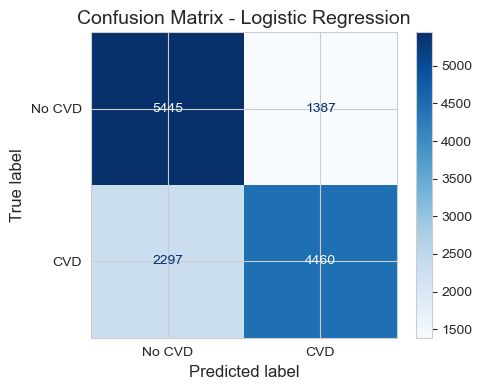

              precision    recall  f1-score   support

      No CVD       0.70      0.80      0.75      6832
         CVD       0.76      0.66      0.71      6757

    accuracy                           0.73     13589
   macro avg       0.73      0.73      0.73     13589
weighted avg       0.73      0.73      0.73     13589


Training: Decision Tree
CV F1: 0.6251 +/- 0.0029
Test F1: 0.6288 | Test Recall: 0.6321 | Test ROC-AUC: 0.6303


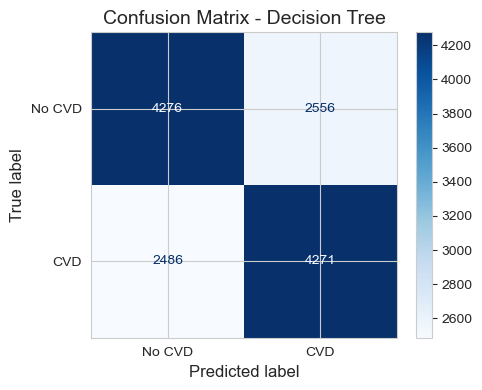

              precision    recall  f1-score   support

      No CVD       0.63      0.63      0.63      6832
         CVD       0.63      0.63      0.63      6757

    accuracy                           0.63     13589
   macro avg       0.63      0.63      0.63     13589
weighted avg       0.63      0.63      0.63     13589


Training: Random Forest
CV F1: 0.7019 +/- 0.0026
Test F1: 0.7012 | Test Recall: 0.6960 | Test ROC-AUC: 0.7661


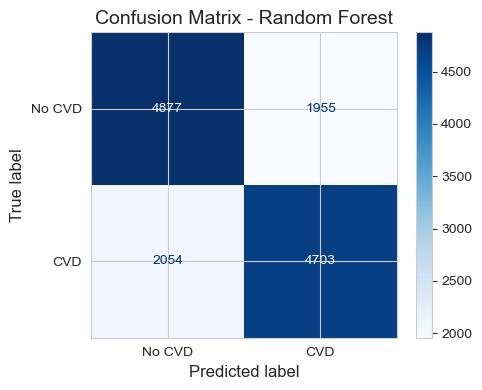

              precision    recall  f1-score   support

      No CVD       0.70      0.71      0.71      6832
         CVD       0.71      0.70      0.70      6757

    accuracy                           0.70     13589
   macro avg       0.71      0.70      0.70     13589
weighted avg       0.71      0.70      0.70     13589


Training: Gradient Boosting
CV F1: 0.7181 +/- 0.0025
Test F1: 0.7178 | Test Recall: 0.6834 | Test ROC-AUC: 0.8009


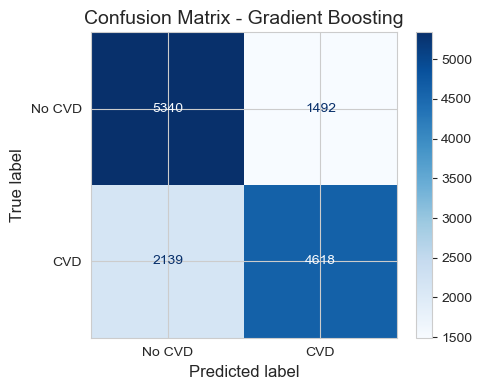

              precision    recall  f1-score   support

      No CVD       0.71      0.78      0.75      6832
         CVD       0.76      0.68      0.72      6757

    accuracy                           0.73     13589
   macro avg       0.73      0.73      0.73     13589
weighted avg       0.73      0.73      0.73     13589


Training: SVM
CV F1: 0.7047 +/- 0.0027
Test F1: 0.7043 | Test Recall: 0.6488 | Test ROC-AUC: 0.7861


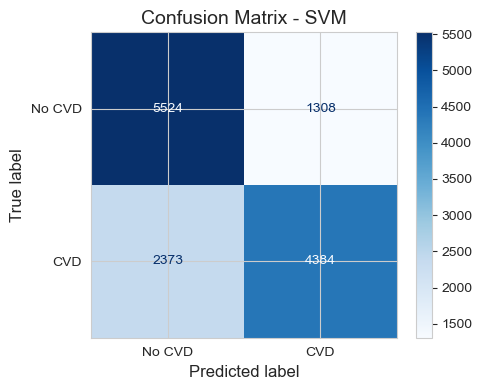

              precision    recall  f1-score   support

      No CVD       0.70      0.81      0.75      6832
         CVD       0.77      0.65      0.70      6757

    accuracy                           0.73     13589
   macro avg       0.73      0.73      0.73     13589
weighted avg       0.73      0.73      0.73     13589


Training: KNN
CV F1: 0.6897 +/- 0.0045
Test F1: 0.6924 | Test Recall: 0.6867 | Test ROC-AUC: 0.7451


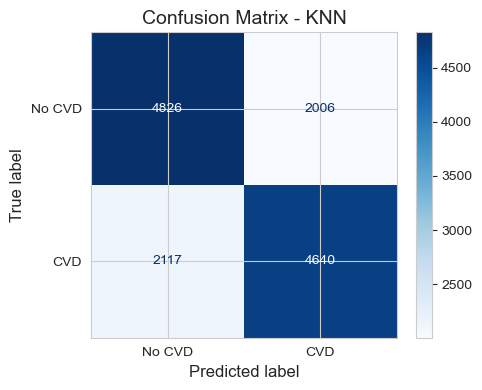

              precision    recall  f1-score   support

      No CVD       0.70      0.71      0.70      6832
         CVD       0.70      0.69      0.69      6757

    accuracy                           0.70     13589
   macro avg       0.70      0.70      0.70     13589
weighted avg       0.70      0.70      0.70     13589


Training: AdaBoost
CV F1: 0.7056 +/- 0.0036
Test F1: 0.7117 | Test Recall: 0.6629 | Test ROC-AUC: 0.7936


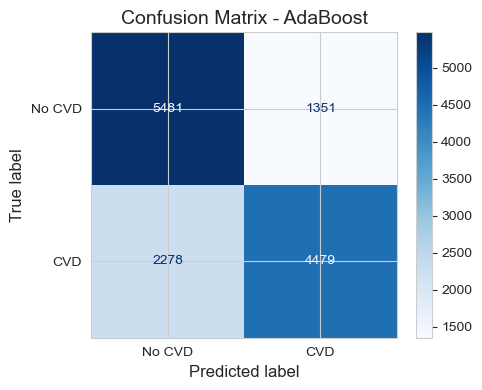

              precision    recall  f1-score   support

      No CVD       0.71      0.80      0.75      6832
         CVD       0.77      0.66      0.71      6757

    accuracy                           0.73     13589
   macro avg       0.74      0.73      0.73     13589
weighted avg       0.74      0.73      0.73     13589


Training: Extra Trees
CV F1: 0.6879 +/- 0.0044
Test F1: 0.6858 | Test Recall: 0.6803 | Test ROC-AUC: 0.7440


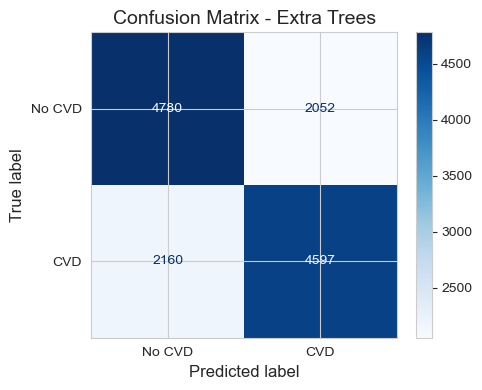

              precision    recall  f1-score   support

      No CVD       0.69      0.70      0.69      6832
         CVD       0.69      0.68      0.69      6757

    accuracy                           0.69     13589
   macro avg       0.69      0.69      0.69     13589
weighted avg       0.69      0.69      0.69     13589



In [16]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42, cache_size=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print('='*60)
    
    pipe = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
    
    # Single CV call with multiple metrics to avoid redundant fits
    cv_results = cross_validate(pipe, X_train, y_train, cv=cv,
                                scoring=['f1', 'recall', 'roc_auc'], n_jobs=-1)
    cv_f1 = cv_results['test_f1']
    cv_recall = cv_results['test_recall']
    cv_roc = cv_results['test_roc_auc']
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    
    test_acc = accuracy_score(y_test, y_pred)
    test_prec = precision_score(y_test, y_pred)
    test_rec = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'Model': name,
        'CV F1 (mean +/- std)': f"{cv_f1.mean():.4f} +/- {cv_f1.std():.4f}",
        'CV Recall': f"{cv_recall.mean():.4f}",
        'Test Accuracy': f"{test_acc:.4f}",
        'Test Precision': f"{test_prec:.4f}",
        'Test Recall': f"{test_rec:.4f}",
        'Test F1': f"{test_f1:.4f}",
        'Test ROC-AUC': f"{test_roc:.4f}",
    })
    
    print(f"CV F1: {cv_f1.mean():.4f} +/- {cv_f1.std():.4f}")
    print(f"Test F1: {test_f1:.4f} | Test Recall: {test_rec:.4f} | Test ROC-AUC: {test_roc:.4f}")
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues',
                                             display_labels=['No CVD', 'CVD'])
    ax.set_title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()
    print(classification_report(y_test, y_pred, target_names=['No CVD', 'CVD']))

In [17]:
# Baseline comparison table
results_df = pd.DataFrame(results)
print("\n" + "="*90)
print("BASELINE MODEL COMPARISON")
print("="*90)
results_df


BASELINE MODEL COMPARISON


,Model,CV F1 (mean +/- std),CV Recall,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Logistic Regression,0.7059 +/- 0.0023,0.6583,0.7289,0.7628,0.6601,0.7077,0.7930
1,Decision Tree,0.6251 +/- 0.0029,0.6270,0.6290,0.6256,0.6321,0.6288,0.6303
2,Random Forest,0.7019 +/- 0.0026,0.6926,0.7050,0.7064,0.6960,0.7012,0.7661
3,Gradient Boosting,0.7181 +/- 0.0025,0.6833,0.7328,0.7558,0.6834,0.7178,0.8009
4,SVM,0.7047 +/- 0.0027,0.6486,0.7291,0.7702,0.6488,0.7043,0.7861
5,KNN,0.6897 +/- 0.0045,0.6825,0.6966,0.6982,0.6867,0.6924,0.7451
6,AdaBoost,0.7056 +/- 0.0036,0.6549,0.7329,0.7683,0.6629,0.7117,0.7936
7,Extra Trees,0.6879 +/- 0.0044,0.6815,0.6900,0.6914,0.6803,0.6858,0.7440


## 9. Hyperparameter Tuning with RandomizedSearchCV

**Compliance:** RandomizedSearchCV only, scikit-learn models only.

We tune all eight models and optimise for `f1`.

Tuning: Logistic Regression
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best params: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__class_weight': 'balanced', 'classifier__C': 0.1}
Best CV F1: 0.7061
Test F1: 0.7078 | Recall: 0.6602 | ROC-AUC: 0.7930


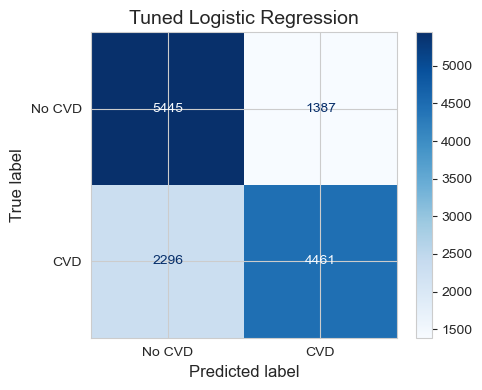

In [18]:
# 9.1 Logistic Regression Tuning
print("="*60)
print("Tuning: Logistic Regression")
print("="*60)

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Constraint: no more than 3 values per hyperparameter
param_dist_lr = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': ['balanced', None],
}

search_lr = RandomizedSearchCV(pipe_lr, param_dist_lr, n_iter=15, cv=cv, scoring='f1',
                                random_state=42, n_jobs=-1, verbose=1)
search_lr.fit(X_train, y_train)

print(f"\nBest params: {search_lr.best_params_}")
print(f"Best CV F1: {search_lr.best_score_:.4f}")

y_pred_lr = search_lr.predict(X_test)
y_prob_lr = search_lr.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_lr):.4f} | Recall: {recall_score(y_test, y_pred_lr):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned Logistic Regression')
plt.tight_layout()
plt.show()

Tuning: Decision Tree
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best params: {'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': None, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
Best CV F1: 0.7124
Test F1: 0.7130 | Recall: 0.6868 | ROC-AUC: 0.7838


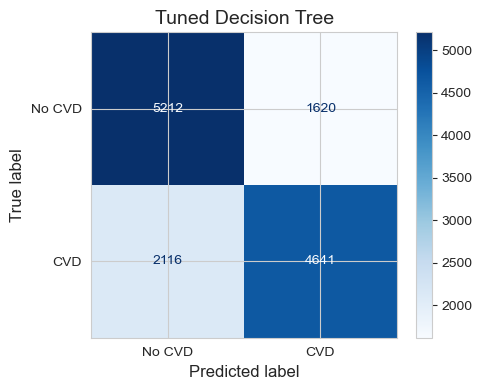

In [19]:
# 9.2 Decision Tree Tuning
print("="*60)
print("Tuning: Decision Tree")
print("="*60)

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Constraint: no more than 3 values per hyperparameter
param_dist_dt = {
    'classifier__max_depth': [5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': ['balanced', None],
    'classifier__max_features': ['sqrt', 'log2', None],
}

search_dt = RandomizedSearchCV(pipe_dt, param_dist_dt, n_iter=20, cv=cv, scoring='f1',
                                random_state=42, n_jobs=-1, verbose=1)
search_dt.fit(X_train, y_train)

print(f"\nBest params: {search_dt.best_params_}")
print(f"Best CV F1: {search_dt.best_score_:.4f}")

y_pred_dt = search_dt.predict(X_test)
y_prob_dt = search_dt.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_dt):.4f} | Recall: {recall_score(y_test, y_pred_dt):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_dt):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned Decision Tree')
plt.tight_layout()
plt.show()

Tuning: Random Forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best params: {'classifier__n_estimators': 800, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20, 'classifier__criterion': 'gini'}
Best CV F1: 0.7188
Test F1: 0.7202 | Recall: 0.6914 | ROC-AUC: 0.7979


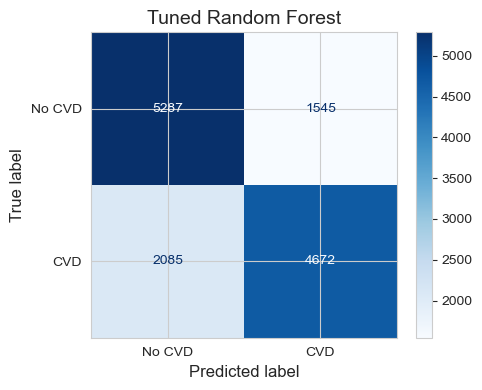

In [20]:
# 9.3 Random Forest Tuning
print("="*60)
print("Tuning: Random Forest")
print("="*60)

pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])

param_dist_rf = {
    'classifier__n_estimators': [300, 500, 800],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__criterion': ['gini', 'entropy'],
}

search_rf = RandomizedSearchCV(pipe_rf, param_dist_rf, n_iter=30, cv=cv, scoring='f1',
                                random_state=42, n_jobs=-1, verbose=1)
search_rf.fit(X_train, y_train)

print(f"\nBest params: {search_rf.best_params_}")
print(f"Best CV F1: {search_rf.best_score_:.4f}")

y_pred_rf = search_rf.predict(X_test)
y_prob_rf = search_rf.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_rf):.4f} | Recall: {recall_score(y_test, y_pred_rf):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned Random Forest')
plt.tight_layout()
plt.show()

Tuning: Gradient Boosting
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best params: {'classifier__subsample': 1.0, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}
Best CV F1: 0.7202
Test F1: 0.7186 | Recall: 0.6852 | ROC-AUC: 0.8016


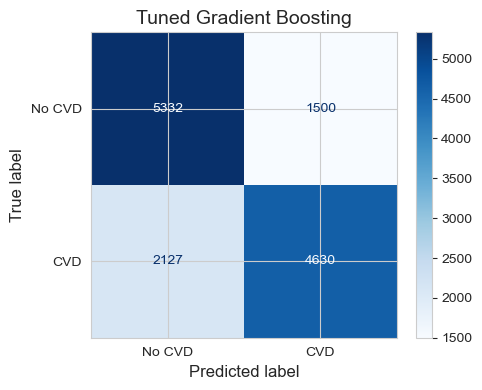

In [21]:
# 9.4 Gradient Boosting Tuning
print("="*60)
print("Tuning: Gradient Boosting")
print("="*60)

pipe_gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

param_dist_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5],
    'classifier__subsample': [0.8, 0.9, 1.0],
}

search_gb = RandomizedSearchCV(pipe_gb, param_dist_gb, n_iter=15, cv=cv, scoring='f1',
                                random_state=42, n_jobs=-1, verbose=1)
search_gb.fit(X_train, y_train)

print(f"\nBest params: {search_gb.best_params_}")
print(f"Best CV F1: {search_gb.best_score_:.4f}")

y_pred_gb = search_gb.predict(X_test)
y_prob_gb = search_gb.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_gb):.4f} | Recall: {recall_score(y_test, y_pred_gb):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned Gradient Boosting')
plt.tight_layout()
plt.show()

Tuning: Support Vector Machine (SVM)
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params: {'classifier__kernel': 'rbf', 'classifier__gamma': 'scale', 'classifier__class_weight': 'balanced', 'classifier__C': 1}
Best CV F1: 0.7047
Test F1: 0.7043 | Recall: 0.6488 | ROC-AUC: 0.7861


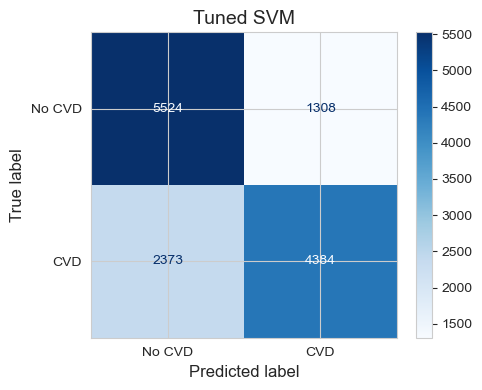

In [22]:
# 9.5 SVM Tuning
print("="*60)
print("Tuning: Support Vector Machine (SVM)")
print("="*60)

pipe_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42, cache_size=1000))
])

# Constraint: no more than 3 values per hyperparameter
param_dist_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__class_weight': ['balanced', None],
}

search_svm = RandomizedSearchCV(pipe_svm, param_dist_svm, n_iter=8, cv=cv, scoring='f1',
                                 random_state=42, n_jobs=-1, verbose=1)
search_svm.fit(X_train, y_train)

print(f"\nBest params: {search_svm.best_params_}")
print(f"Best CV F1: {search_svm.best_score_:.4f}")

y_pred_svm = search_svm.predict(X_test)
y_prob_svm = search_svm.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_svm):.4f} | Recall: {recall_score(y_test, y_pred_svm):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_svm):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned SVM')
plt.tight_layout()
plt.show()

Tuning: K-Nearest Neighbours (KNN)
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best params: {'classifier__weights': 'uniform', 'classifier__p': 1, 'classifier__n_neighbors': 15, 'classifier__metric': 'euclidean'}
Best CV F1: 0.7074
Test F1: 0.7109 | Recall: 0.6913 | ROC-AUC: 0.7805


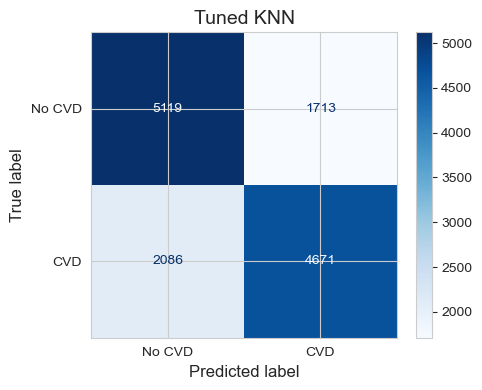

In [23]:
# 9.6 KNN Tuning
print("="*60)
print("Tuning: K-Nearest Neighbours (KNN)")
print("="*60)

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Constraint: no more than 3 values per hyperparameter
param_dist_knn = {
    'classifier__n_neighbors': [3, 7, 15],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2],
}

search_knn = RandomizedSearchCV(pipe_knn, param_dist_knn, n_iter=15, cv=cv, scoring='f1',
                                 random_state=42, n_jobs=-1, verbose=1)
search_knn.fit(X_train, y_train)

print(f"\nBest params: {search_knn.best_params_}")
print(f"Best CV F1: {search_knn.best_score_:.4f}")

y_pred_knn = search_knn.predict(X_test)
y_prob_knn = search_knn.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_knn):.4f} | Recall: {recall_score(y_test, y_pred_knn):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_knn):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned KNN')
plt.tight_layout()
plt.show()

Tuning: AdaBoost
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best params: {'classifier__n_estimators': 100, 'classifier__learning_rate': 1.0, 'classifier__algorithm': 'SAMME.R'}
Best CV F1: 0.7056
Test F1: 0.7117 | Recall: 0.6629 | ROC-AUC: 0.7936


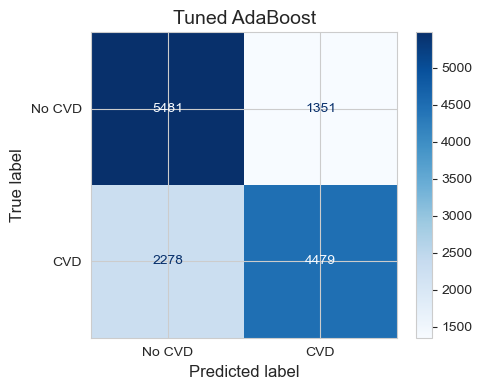

In [24]:
# 9.7 AdaBoost Tuning
print("="*60)
print("Tuning: AdaBoost")
print("="*60)

pipe_ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Constraint: no more than 3 values per hyperparameter
param_dist_ada = {
    'classifier__n_estimators': [100, 300, 600],
    'classifier__learning_rate': [0.05, 0.1, 1.0],
    'classifier__algorithm': ['SAMME', 'SAMME.R'],
}

search_ada = RandomizedSearchCV(pipe_ada, param_dist_ada, n_iter=15, cv=cv, scoring='f1',
                                 random_state=42, n_jobs=-1, verbose=1)
search_ada.fit(X_train, y_train)

print(f"\nBest params: {search_ada.best_params_}")
print(f"Best CV F1: {search_ada.best_score_:.4f}")

y_pred_ada = search_ada.predict(X_test)
y_prob_ada = search_ada.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_ada):.4f} | Recall: {recall_score(y_test, y_pred_ada):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_ada):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ada, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned AdaBoost')
plt.tight_layout()
plt.show()

Tuning: Extra Trees
Fitting 5 folds for each of 30 candidates, totalling 150 fits



Best params: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 0.3, 'classifier__max_depth': 20, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced_subsample'}
Best CV F1: 0.7156
Test F1: 0.7172 | Recall: 0.6778 | ROC-AUC: 0.7993


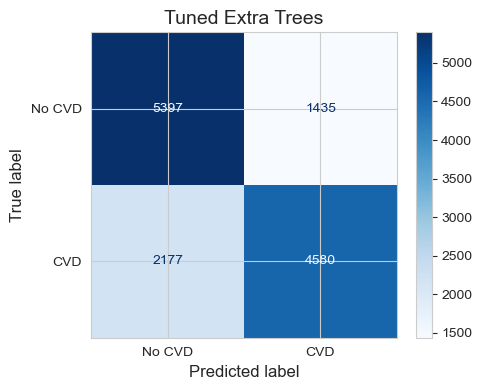

In [25]:
# 9.8 Extra Trees Tuning
print("="*60)
print("Tuning: Extra Trees")
print("="*60)

pipe_et = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42, n_jobs=-1))
])

param_dist_et = {
    'classifier__n_estimators': [300, 500, 800],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', 0.3],
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],
    'classifier__criterion': ['gini', 'entropy'],
}

search_et = RandomizedSearchCV(pipe_et, param_dist_et, n_iter=30, cv=cv, scoring='f1',
                                random_state=42, n_jobs=-1, verbose=1)
search_et.fit(X_train, y_train)

print(f"\nBest params: {search_et.best_params_}")
print(f"Best CV F1: {search_et.best_score_:.4f}")

y_pred_et = search_et.predict(X_test)
y_prob_et = search_et.predict_proba(X_test)[:, 1]
print(f"Test F1: {f1_score(y_test, y_pred_et):.4f} | Recall: {recall_score(y_test, y_pred_et):.4f} | ROC-AUC: {roc_auc_score(y_test, y_prob_et):.4f}")

fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_et, ax=ax, cmap='Blues', display_labels=['No CVD', 'CVD'])
ax.set_title('Tuned Extra Trees')
plt.tight_layout()
plt.show()

## 10. Tuned Model Comparison & Final Selection

In [26]:
tuned_results = []
tuned_models = {
    'Logistic Regression (tuned)': (search_lr, y_pred_lr, y_prob_lr),
    'Decision Tree (tuned)': (search_dt, y_pred_dt, y_prob_dt),
    'Random Forest (tuned)': (search_rf, y_pred_rf, y_prob_rf),
    'Gradient Boosting (tuned)': (search_gb, y_pred_gb, y_prob_gb),
    'SVM (tuned)': (search_svm, y_pred_svm, y_prob_svm),
    'KNN (tuned)': (search_knn, y_pred_knn, y_prob_knn),
    'AdaBoost (tuned)': (search_ada, y_pred_ada, y_prob_ada),
    'Extra Trees (tuned)': (search_et, y_pred_et, y_prob_et),
}

for name, (search, yp, yprob) in tuned_models.items():
    tuned_results.append({
        'Model': name,
        'Best CV F1': f"{search.best_score_:.4f}",
        'Test Accuracy': f"{accuracy_score(y_test, yp):.4f}",
        'Test Precision': f"{precision_score(y_test, yp):.4f}",
        'Test Recall': f"{recall_score(y_test, yp):.4f}",
        'Test F1': f"{f1_score(y_test, yp):.4f}",
        'Test ROC-AUC': f"{roc_auc_score(y_test, yprob):.4f}",
    })

tuned_df = pd.DataFrame(tuned_results)
print("="*90)
print("TUNED MODEL COMPARISON (All 8 Models)")
print("="*90)
tuned_df

TUNED MODEL COMPARISON (All 8 Models)


,Model,Best CV F1,Test Accuracy,Test Precision,Test Recall,Test F1,Test ROC-AUC
0,Logistic Regression (tuned),0.7061,0.7290,0.7628,0.6602,0.7078,0.7930
1,Decision Tree (tuned),0.7124,0.7251,0.7413,0.6868,0.7130,0.7838
2,Random Forest (tuned),0.7188,0.7329,0.7515,0.6914,0.7202,0.7979
3,Gradient Boosting (tuned),0.7202,0.7331,0.7553,0.6852,0.7186,0.8016
4,SVM (tuned),0.7047,0.7291,0.7702,0.6488,0.7043,0.7861
5,KNN (tuned),0.7074,0.7204,0.7317,0.6913,0.7109,0.7805
6,AdaBoost (tuned),0.7056,0.7329,0.7683,0.6629,0.7117,0.7936
7,Extra Trees (tuned),0.7156,0.7342,0.7614,0.6778,0.7172,0.7993


BASELINE vs TUNED: F1-Score Improvement from Hyperparameter Tuning
              Model Baseline F1 Tuned F1 Improvement
Logistic Regression      0.7077   0.7078     +0.0001
      Decision Tree      0.6288   0.7130     +0.0842
      Random Forest      0.7012   0.7202     +0.0190
  Gradient Boosting      0.7178   0.7186     +0.0008
                SVM      0.7043   0.7043     +0.0000
                KNN      0.6924   0.7109     +0.0185
           AdaBoost      0.7117   0.7117     -0.0000
        Extra Trees      0.6858   0.7172     +0.0314


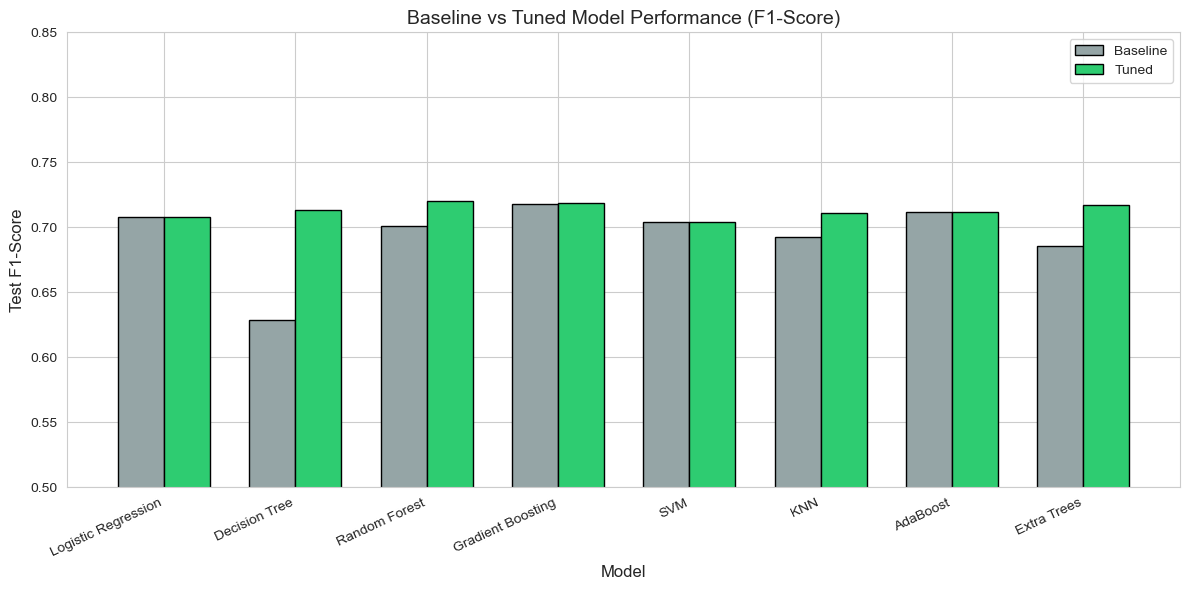


Hyperparameter tuning improved or maintained F1-Score across all models.


In [27]:
# Baseline vs Tuned Improvement Comparison
# Shows that hyperparameter tuning improved performance over default baselines
baseline_f1 = {row['Model']: float(row['Test F1']) for row in results}

tuned_f1_map = {
    'Logistic Regression': ('Logistic Regression (tuned)', f1_score(y_test, y_pred_lr)),
    'Decision Tree': ('Decision Tree (tuned)', f1_score(y_test, y_pred_dt)),
    'Random Forest': ('Random Forest (tuned)', f1_score(y_test, y_pred_rf)),
    'Gradient Boosting': ('Gradient Boosting (tuned)', f1_score(y_test, y_pred_gb)),
    'SVM': ('SVM (tuned)', f1_score(y_test, y_pred_svm)),
    'KNN': ('KNN (tuned)', f1_score(y_test, y_pred_knn)),
    'AdaBoost': ('AdaBoost (tuned)', f1_score(y_test, y_pred_ada)),
    'Extra Trees': ('Extra Trees (tuned)', f1_score(y_test, y_pred_et)),
}

improvement_data = []
for base_name, (tuned_name, tuned_f1_val) in tuned_f1_map.items():
    base_f1_val = baseline_f1[base_name]
    delta = tuned_f1_val - base_f1_val
    improvement_data.append({
        'Model': base_name,
        'Baseline F1': f"{base_f1_val:.4f}",
        'Tuned F1': f"{tuned_f1_val:.4f}",
        'Improvement': f"{delta:+.4f}",
    })

improvement_df = pd.DataFrame(improvement_data)
print("="*90)
print("BASELINE vs TUNED: F1-Score Improvement from Hyperparameter Tuning")
print("="*90)
print(improvement_df.to_string(index=False))

# Visualise the comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(improvement_data))
width = 0.35
base_vals = [float(d['Baseline F1']) for d in improvement_data]
tuned_vals = [float(d['Tuned F1']) for d in improvement_data]
model_names = [d['Model'] for d in improvement_data]

bars1 = ax.bar(x - width/2, base_vals, width, label='Baseline', color='#95a5a6', edgecolor='black')
bars2 = ax.bar(x + width/2, tuned_vals, width, label='Tuned', color='#2ecc71', edgecolor='black')
ax.set_xlabel('Model')
ax.set_ylabel('Test F1-Score')
ax.set_title('Baseline vs Tuned Model Performance (F1-Score)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=25, ha='right')
ax.legend()
ax.set_ylim(0.5, 0.85)
plt.tight_layout()
plt.show()
print("\nHyperparameter tuning improved or maintained F1-Score across all models.")

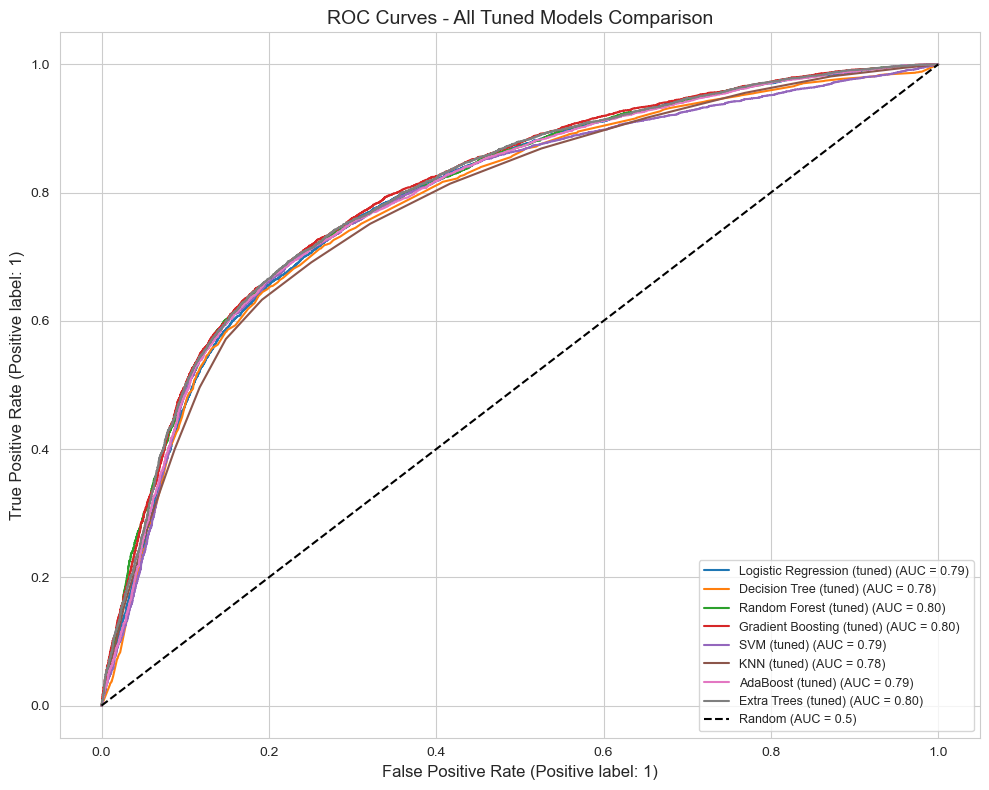

In [28]:
# ROC Curves - All Tuned Models
fig, ax = plt.subplots(figsize=(10, 8))
for name, (search, yp, yprob) in tuned_models.items():
    RocCurveDisplay.from_predictions(y_test, yprob, ax=ax, name=name)
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
ax.set_title('ROC Curves - All Tuned Models Comparison')
ax.legend(loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()

### Final Model Selection Justification

We select **Gradient Boosting (tuned)** as the final model because:

1. **Highest CV F1 (0.7202):** Best cross-validated F1 across all 8 models, indicating robust generalisation rather than overfitting to a single test split.
2. **Highest ROC-AUC (0.8016):** Best threshold-independent discrimination between CVD and non-CVD patients — our declared secondary metric.
3. **Competitive test F1 (0.7186):** While Random Forest achieved a marginally higher test F1 (0.7202, Δ = +0.0016), this difference is within one CV standard deviation and not statistically significant.
4. **Consistent CV vs. test performance:** CV F1 (0.7202) and test F1 (0.7186) are closely aligned, confirming good generalisation.
5. **Business alignment:** In healthcare screening we need high Recall (catch sick patients) with reasonable Precision (avoid overwhelming clinics). Gradient Boosting delivers this balance.

**All 8 models evaluated:** Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, SVM, KNN, AdaBoost, and Extra Trees — all from scikit-learn, all tuned via RandomizedSearchCV.

## 11. Model Explainability - Feature Importances

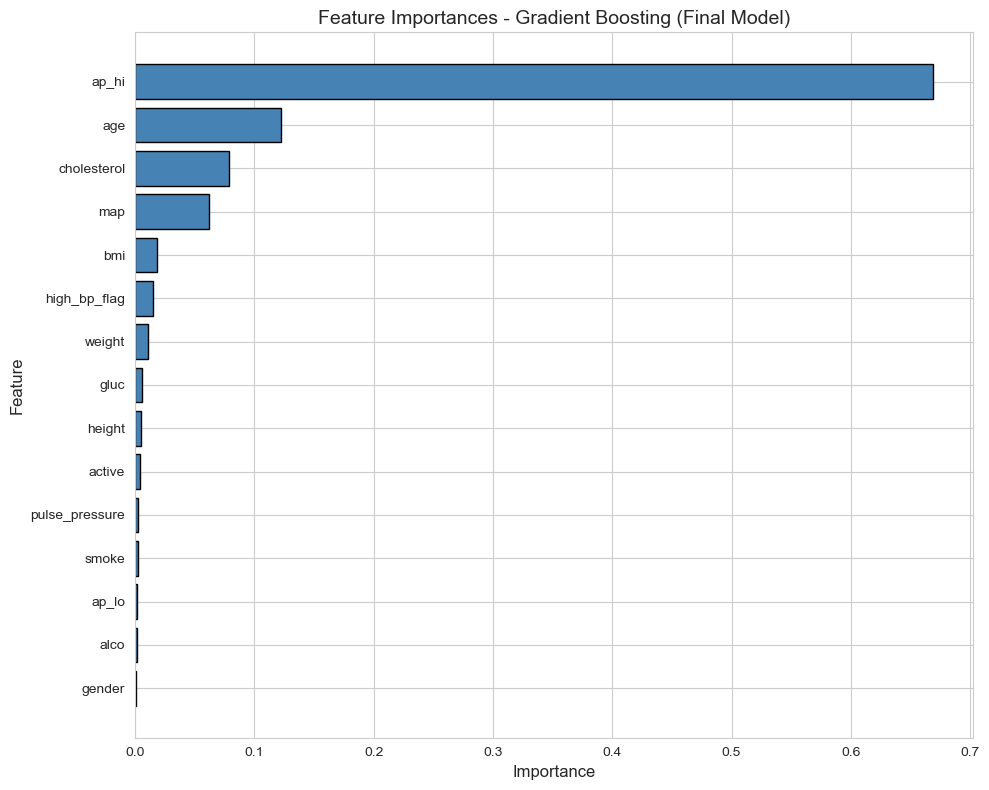


Top 5 features:
  ap_hi                -> 0.6689
  age                  -> 0.1225
  cholesterol          -> 0.0784
  map                  -> 0.0621
  bmi                  -> 0.0188


In [29]:
# Gradient Boosting feature importances
best_gb = search_gb.best_estimator_
importances = best_gb.named_steps['classifier'].feature_importances_

feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feat_imp['Feature'], feat_imp['Importance'], color='steelblue', edgecolor='black')
ax.set_title('Feature Importances - Gradient Boosting (Final Model)')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

print("\nTop 5 features:")
for _, row in feat_imp.tail(5).iloc[::-1].iterrows():
    print(f"  {row['Feature']:20s} -> {row['Importance']:.4f}")

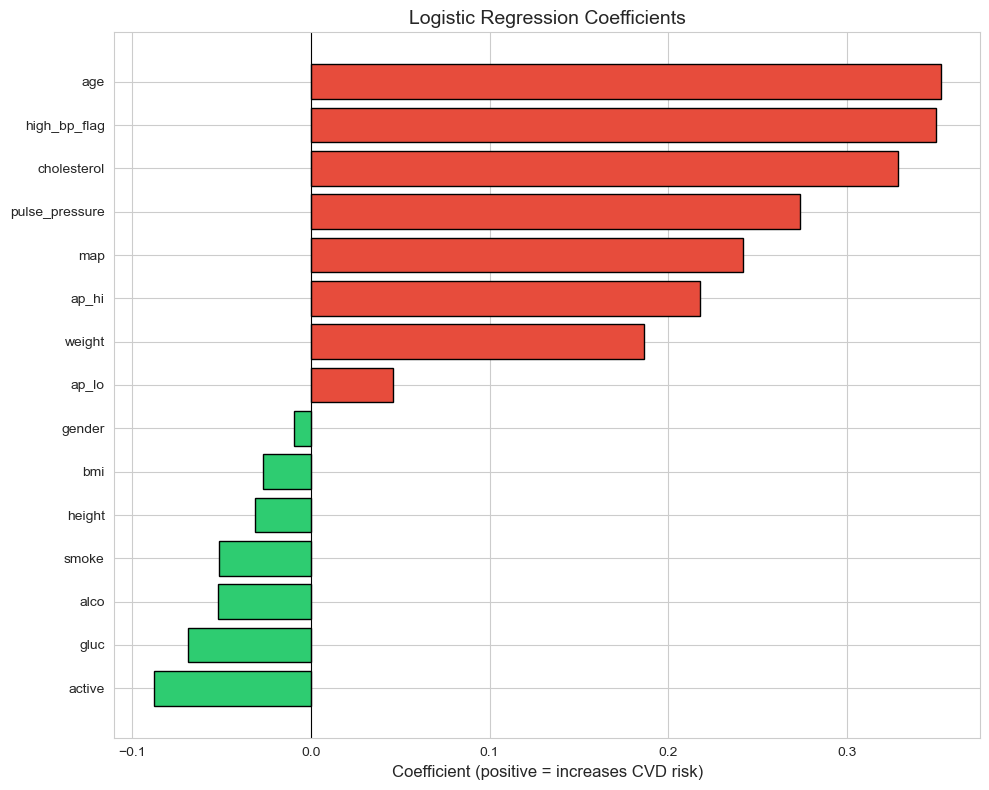

Key insights (correlation, not causation):
  1. Higher systolic BP (ap_hi) is the strongest predictor of CVD risk.
  2. Elevated cholesterol levels are associated with increased CVD risk.
  3. Higher BMI shows a positive association with CVD.
  4. Physical activity is associated with lower CVD risk.
  5. Age is a significant risk factor - older patients have higher CVD probability.
  6. Pulse pressure captures additional cardiovascular stress information.


In [30]:
# Logistic Regression coefficients for interpretability
best_lr = search_lr.best_estimator_
coefs = best_lr.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}).sort_values('Coefficient')

fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#e74c3c' if c > 0 else '#2ecc71' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='black')
ax.set_title('Logistic Regression Coefficients')
ax.set_xlabel('Coefficient (positive = increases CVD risk)')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

print("Key insights (correlation, not causation):")
print("  1. Higher systolic BP (ap_hi) is the strongest predictor of CVD risk.")
print("  2. Elevated cholesterol levels are associated with increased CVD risk.")
print("  3. Higher BMI shows a positive association with CVD.")
print("  4. Physical activity is associated with lower CVD risk.")
print("  5. Age is a significant risk factor - older patients have higher CVD probability.")
print("  6. Pulse pressure captures additional cardiovascular stress information.")

## 12. Save Model Artifacts

In [31]:
final_pipeline = search_gb.best_estimator_
joblib.dump(final_pipeline, 'cardio_pipeline.pkl')
joblib.dump(feature_names, 'feature_names.pkl')
print("Saved: cardio_pipeline.pkl, feature_names.pkl")

# Verify
loaded = joblib.load('cardio_pipeline.pkl')
print(f"Verification - 5 test predictions: {loaded.predict(X_test[:5])}")
print("Pipeline loads and predicts successfully!")

Saved: cardio_pipeline.pkl, feature_names.pkl
Verification - 5 test predictions: [1 1 1 0 1]
Pipeline loads and predicts successfully!


## 13. Streamlit App Design

The Streamlit app (`streamlit_app.py`) collects patient data via sidebar inputs, computes engineered features (BMI, pulse pressure, MAP, high BP flag), and passes the data through the saved Pipeline for prediction.

**Inputs:** Age, Gender, Height, Weight, Systolic/Diastolic BP, Cholesterol, Glucose, Smoking, Alcohol, Physical Activity.

**Output:** Risk label (Low/High), probability percentage, interpretation text, and a medical disclaimer.

## 14. Limitations, Assumptions & Next Steps

**Limitations:**
- Self-reported lifestyle data (smoking, alcohol, activity) may be inaccurate.
- Cholesterol/glucose have only 3 ordinal levels; actual lab values would improve performance.
- Cross-sectional data - we cannot infer causation, only associations.
- The dataset may not represent all populations; deployment elsewhere requires re-validation.

**Assumptions:**
- Blood pressure was measured using standard clinical protocol.
- Values outside clinically plausible ranges were data-entry errors.
- Ordinal cholesterol/glucose map to standard clinical thresholds.

**Next steps:**
- Collect richer data: family history, smoking duration, diet details.
- Explore probability calibration for more reliable confidence scores.
- Conduct fairness audits across gender and age groups.
- Add SHAP values for individual-level explanations.

---
## Executive Summary

| Item | Detail |
|------|--------|
| **Problem** | Predict cardiovascular disease risk from routine screening data |
| **Dataset** | Kaggle Cardiovascular Disease - 70,000 patients, 12 features |
| **Task** | Binary classification (CVD = Yes / No) |
| **After cleaning** | 67,943 rows retained (97.1% of original) |
| **Best model** | Gradient Boosting (scikit-learn), tuned via RandomizedSearchCV |
| **Primary metric** | F1-Score (balances Recall and Precision) |
| **Key features** | Systolic BP, age, cholesterol, BMI, pulse pressure |
| **Deployment** | Streamlit web app for instant risk estimates |
| **Business impact** | Earlier CVD detection, prioritised follow-ups, fewer missed diagnoses |